In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from scipy.signal import find_peaks

In [2]:
with open("Data/baseline.log") as f:
    cycle_count_baseline = []
    for line in f:
        if line[:10] == "[PERF] 0.2":
            cycle_count_baseline.append(int(line[11:15]))

In [3]:
n = 512
mean_baseline = np.mean(np.array(cycle_count_baseline))
print("Baseline")
print(f"Average cycle count: {mean_baseline:.0f}")
print(f"Cycle count / Complexity: {mean_baseline/n:.3f}")

Baseline
Average cycle count: 4180
Cycle count / Complexity: 8.164


In [4]:
with open("Data/optimized.log") as f:
    cycle_count_optimized = []
    for line in f:
        if line[:10] == "[PERF] 0.2":
            cycle_count_optimized.append(int(line[11:15]))

In [5]:
mean_optimized = np.mean(np.array(cycle_count_optimized))
print("Optimized")
print(f"Average cycle count: {mean_optimized:.0f}")
print(f"Cycle count / Complexity: {mean_optimized/n:.3f}")

Optimized
Average cycle count: 1750
Cycle count / Complexity: 3.418


In [6]:
formatter_s = EngFormatter(unit='s')
formatter_w = EngFormatter(unit='W')
def plot_pp(times,chs,labels=None,labels_title=None,title=None,file_path=None):
    plt.rcParams["figure.figsize"] = (8,4)
    for i, (t, ch) in enumerate(zip(times,chs)):
        plt.plot(t,ch,linewidth=.8)
    if labels is not None:
        plt.legend(labels,title=labels_title,bbox_to_anchor=(1.01, 1),loc='upper left', borderaxespad=0.,fontsize=14,title_fontsize=16)
    if title is not None:
        plt.title(title,fontsize=18)
    plt.grid()
    plt.gca().xaxis.set_major_formatter(formatter_s)
    plt.gca().yaxis.set_major_formatter(formatter_w)
    plt.ylabel('power',fontsize=16)
    plt.xlabel('time',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    if file_path is not None:
        plt.savefig(file_path)
    plt.show()

In [7]:
pp_baseline  = pd.read_csv("Data/baseline.csv",  delimiter=',',skiprows=7, index_col=0)
pp_optimized = pd.read_csv("Data/optimized.csv", delimiter=',',skiprows=7, index_col=0)
pps = [pp_baseline, pp_optimized]

for i,pp in enumerate(pps):
    pp['CH1(V)'] = (3.3 - pp['CH1(V)']) * pp['CH1(V)'] / 177
    pp.rename(columns={'CH1(V)': 'CH1(W)'},inplace=True)

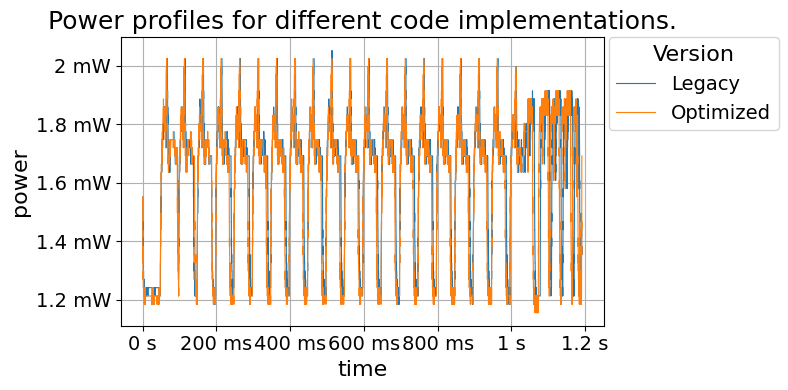

In [8]:
npps = []
for ind, pp in enumerate(pps):
    
    peaks, _ = find_peaks(pp['CH1(W)'].values, prominence=.0001)
    
    for i, peak in enumerate(pp['CH1(W)'][peaks].values):
        
        if pp['CH1(W)'][peaks].values[0] - peak < -0.00005:
            break

    start = peaks[i-1]
    time = pp['Time(S)'][start:].values - pp['Time(S)'][start]
    x = pp['CH1(W)'][start:]

    stop = np.argmin(np.abs(time-1.191))

    npp = pd.DataFrame(dtype=float)    
    npp['t'] = time[:stop]
    npp['w'] = x[:stop].values
    npps.append(npp)

times = [npp['t'] for npp in npps]
chs   = [npp['w'] for npp in npps]
labels = ["Legacy", "Optimized"]
labels_title = "Version"
title = "Power profiles for different code implementations."
plot_pp(times,chs,labels,labels_title,title,'Export/pp.pdf')

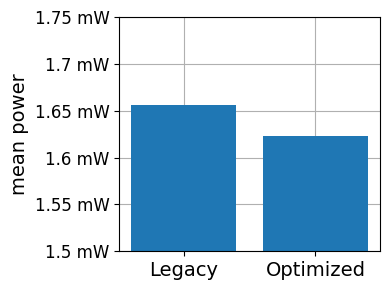

Legacy:    1.656 mW
Optimized: 1.623 mW


In [9]:
means = np.array([np.mean(npp['w']) for npp in npps])
plt.rcParams["figure.figsize"] = (4,3)
plt.bar(labels, means)
plt.ylim(1.5e-3,1.75e-3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(formatter_w)
plt.ylabel('mean power',fontsize=14)
plt.gca().set_axisbelow(True)
plt.grid()
plt.tight_layout()
plt.savefig('Export/bar.pdf')
plt.show()
print(f"Legacy:    {means[0]*1e3:.3f} mW")
print(f"Optimized: {means[1]*1e3:.3f} mW")